In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset

from PIL import Image
import os

from utils import *
from unet import *
from attention import *
from time_embedding import *
from vae import *
from ddpm import *


In [2]:
import matplotlib.pyplot as plt

def show_image(image, idx, msg=None):
    single_image = image[idx].detach().cpu().permute(1, 2, 0).numpy()
    # plt.figure(figsize=(32, 32))
    plt.imshow(single_image)
    plt.title(f'{msg} Image')
    plt.axis('off')
    plt.show()


In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.file_list = []

        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            files = os.listdir(class_path)
            self.file_list.extend([(cls, os.path.join(class_path, file)) for file in files])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        class_name, img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")

        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label



In [4]:
batch_size = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
transform = transforms.Compose([
                transforms.ToTensor(), 
                # transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((32, 32), antialias=True),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

train_dataset = CustomDataset(root_dir="./data/catsdogs/", transform=transform)

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
for X, y in train_dataloader:
    print(X.shape)

torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])


In [7]:
ddpm = DDPM(0.0001, 0.02, 1000, device)
unet = UNET(n_classes=2, in_channels=3, out_channels=3, channels=(32,64,128,256)).to(device)

In [8]:
def init_weights(m):
    if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, a=0.1)
unet.apply(init_weights);

In [9]:
lr = 1e-3
epochs = 1000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
len_dataloader = len(train_dataloader)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len_dataloader)

In [10]:
from IPython.display import display
from tqdm.notebook import trange
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

def train(model, epochs=None):
    model.to(device)
    progress_bar = trange(epochs, desc="Progress")
    display(progress_bar)
    for epoch in progress_bar:
        model.train()
        total_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            # print(X.shape)
            xt, t, noise = ddpm.schedule(X)
            # print(xt.shape)
            # print(noise.shape)
            pred = model(xt, t, y)
            # print(pred.shape)
            loss = loss_fn(pred, noise)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            schedular.step()
        current_epoch = epoch+1
        if current_epoch % 50 == 0:
            torch.save(model.state_dict(), f"./Saved Models/unet_schedular_cd_{current_epoch}")
            print(f"Epoch: {current_epoch} - Loss: {total_loss/len_dataloader}")

In [11]:
train(unet, epochs=epochs)

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 50 - Loss: 0.9992006868124008
Epoch: 100 - Loss: 0.23317822441458702
Epoch: 150 - Loss: 0.13525295443832874
Epoch: 200 - Loss: 0.0758369080722332
Epoch: 250 - Loss: 0.08479371480643749
Epoch: 300 - Loss: 1.0169149041175842


KeyboardInterrupt: 

In [13]:
unet.load_state_dict(torch.load("./Saved Models/unet_schedular_cd_200"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


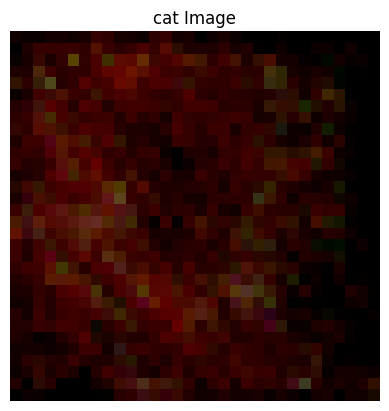

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


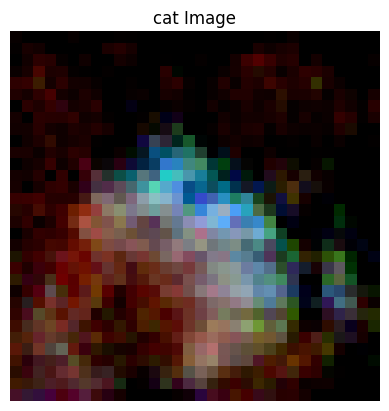

In [14]:
sample = ddpm.sample(unet, (2, 3, 32, 32), torch.tensor(0))
show_image(sample[-1], 0, "cat")
show_image(sample[-1], 1, "cat")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


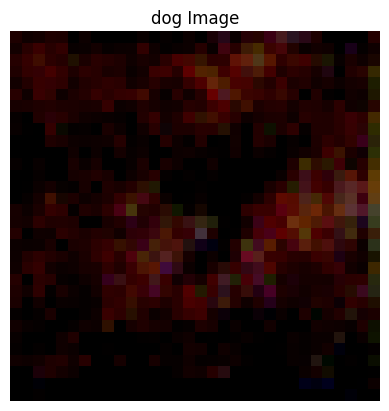

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


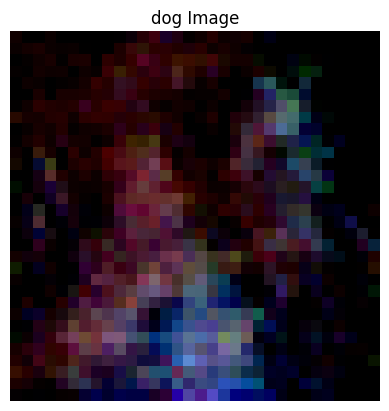

In [17]:
sample = ddpm.sample(unet, (2, 3, 32, 32), torch.tensor(1))
show_image(sample[-1], 0, "dog")
show_image(sample[-1], 1, "dog")